In [1]:
# %pylab nbagg
from tvb.simulator.lab import *

import os.path
from matplotlib import colors, cm
import numpy as np
import time
import scipy.signal as sig
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

2018-03-26 15:23:32,803 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


# Set Directories To Look For Metadata

To simulate the TVB, you will need the connectivity data for this patient.

In [2]:
patient = 'id013_pg'
project_dir = '/Users/adam2392/Documents/pydata/metadata/' + patient

# Initialize Connectivities, Model, Coupling, Integrators and Monitors

Initialize the core parts of the TVB simulator and then simulate

In [3]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
con.speed = np.inf
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources
# normalize
con.weights = con.weights/np.max(con.weights)
nb_regions = len(con.region_labels)

WARNING  File 'hemispheres' not found in ZIP.


In [4]:
x0ez=-1.6
x0pz=-2.4
x0num=-2.4
period=1.

ezind = 0

coupl = coupling.Difference(a=1.)

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)

print nb_regions

# Integrator
hiss = noise.Additive(nsig = np.array([0.001, 0.001, 0., 0.0001, 0.0001, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

# Epileptor model
epileptors = models.Epileptor(Ks=-2, r=0.0002, tau = 10, tt = 0.07)
epileptors.x0 = -2.4*np.ones(nb_regions)
epileptors.x0[ezind] = -1.6

epileptors.state_variable_range['x1'] = np.r_[-0.5, 0.1]
epileptors.state_variable_range['z'] = np.r_[3.5,3.7]
epileptors.state_variable_range['y1'] = np.r_[-0.1,1]
epileptors.state_variable_range['x2'] = np.r_[-2.,0.]
epileptors.state_variable_range['y2'] = np.r_[0.,2.]
epileptors.state_variable_range['g'] = np.r_[-1.,1.]

84


# Add Observation Noise

Here, you have options for adding observation noise into the monitor level. The normal way for creating a monitor for the SEEG signals would be to maybe read in the:

1. seeg xyz positions from a file
2. gain matrix from a file (e.g. from a dipole, mean-field computation)

Then you would normally set different keyword arguments for the monitor, such as period of the signal you want to sample. Here, we can also include a keyword argument called obsnoise, which we can intialize from the noise module.

In [15]:
# adding observation noise?
ntau=2 # color of noise?
noise_cov=np.array([1.0]) # cov of noise
obsnoise = noise.Additive(nsig=noise_cov, ntau=ntau)
obsnoise = noise.Additive(nsig=noise_cov, ntau=ntau)

# monitors
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                                   projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                                   period=period,
                                   variables_of_interest=[0],
                                   obsnoise=obsnoise
                                   )

num_contacts = mon_SEEG.sensors.labels.size

# run simulation
sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,                          
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])

sim.configure()

(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000)

  ERROR  Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


In [16]:
# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

# remove the first 5 seconds of data (from initial conditions) for prettier plotting
ttavg = ttavg[5000:]
tavg = tavg[5000:,...]
seeg = seeg[5000:,...]

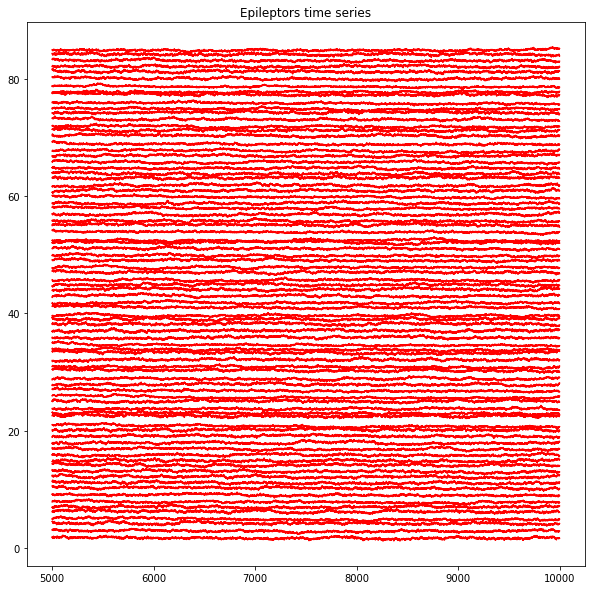

In [17]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))

#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:84], 'r')
plt.title("Epileptors time series")

#Show them
plt.show()

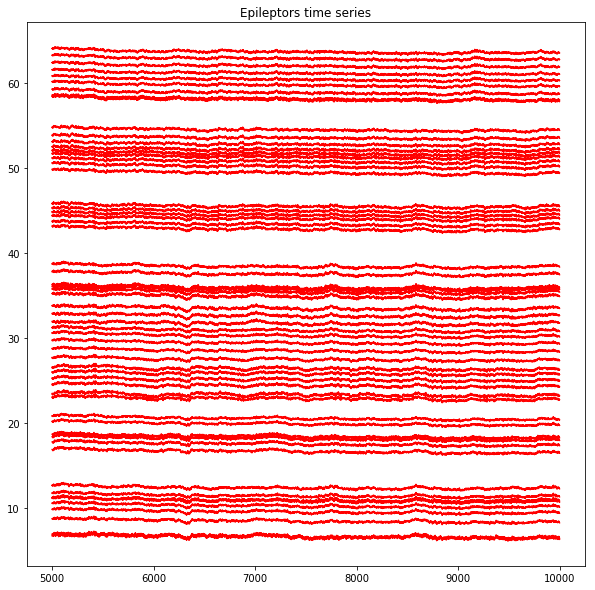

In [18]:
# Normalize the time series to have nice plots
seeg /= (np.max(seeg,0) - np.min(seeg,0 ))

#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(ttavg[:], seeg[:, 0, :, 0] + np.r_[:seeg.shape[2]], 'r')
plt.title("Epileptors time series")

#Show them
plt.show()